<a href="https://colab.research.google.com/github/okech-glitch/python/blob/main/Market_Basket_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
fromfromfromfromfromfrom google.colab import files
uploaded = files.upload()


Saving Online Retail.xlsx to Online Retail.xlsx


** Data Exploration and Cleaning**


In [ ]:
import pandas as pd
# Load the Excel file
df = pd.read_excel('Online Retail.xlsx')

# Display the first few rows of the dataset
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


Summary Statistics

In [ ]:
df.describe()


,Quantity,InvoiceDate,UnitPrice,CustomerID
count,541909.000000,541909,541909.000000,406829.000000
mean,9.552250,2011-07-04 13:34:57.156386048,4.611114,15287.690570
min,-80995.000000,2010-12-01 08:26:00,-11062.060000,12346.000000
25%,1.000000,2011-03-28 11:34:00,1.250000,13953.000000
50%,3.000000,2011-07-19 17:17:00,2.080000,15152.000000
75%,10.000000,2011-10-19 11:27:00,4.130000,16791.000000
max,80995.000000,2011-12-09 12:50:00,38970.000000,18287.000000
std,218.081158,NaN,96.759853,1713.600303


Visualizations

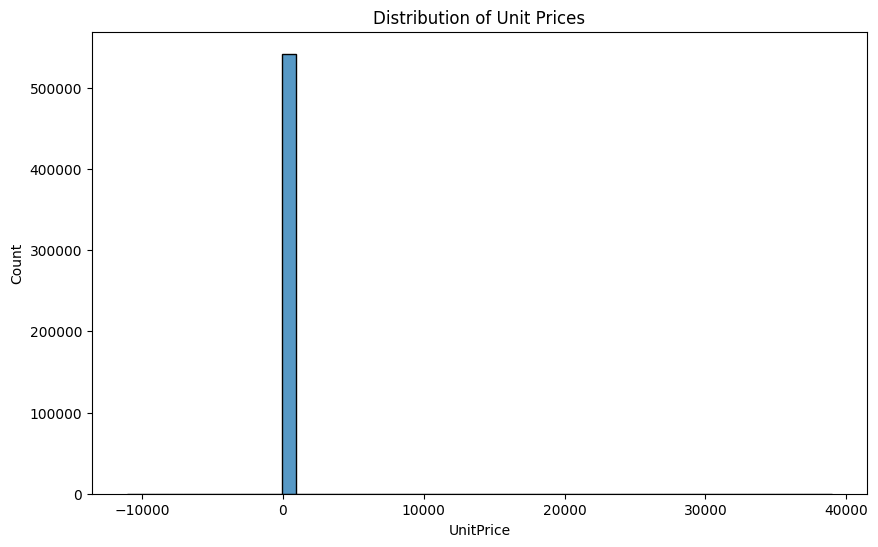

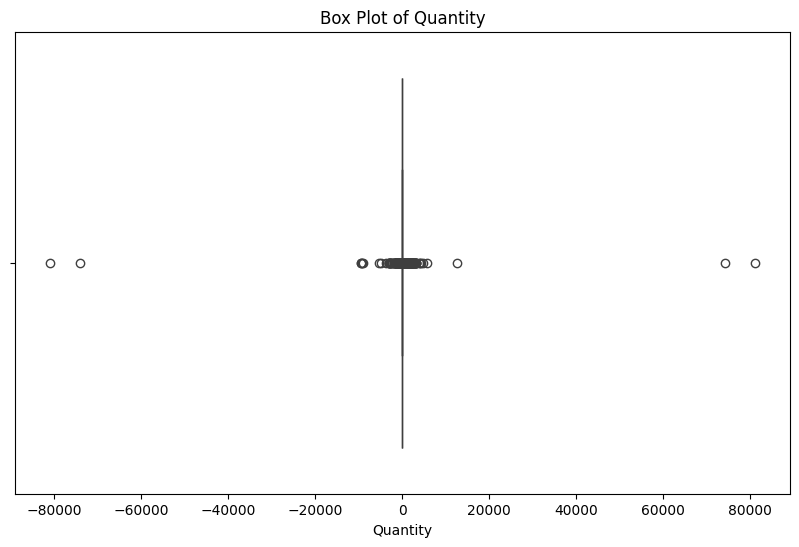

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram for UnitPrice
plt.figure(figsize=(10, 6))
sns.histplot(df['UnitPrice'], bins=50)
plt.title('Distribution of Unit Prices')
plt.show()

# Box plot for Quantity
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['Quantity'])
plt.title('Box Plot of Quantity')
plt.show()


Identified Outliers

In [ ]:
# Z-score method for outlier detection
from scipy import stats
import numpy as np

z_scores = np.abs(stats.zscore(df[['Quantity', 'UnitPrice']]))
df_clean = df[(z_scores < 3).all(axis=1)]


**Feature Engineering**

Transaction-Based Features:

Total Transaction Value: Compute the total value of each transaction by multiplying Quantity by UnitPrice.

In [ ]:
df_clean.loc[:, 'TotalValue'] = df_clean['Quantity'] * df_clean['UnitPrice']


Frequency Features:

Product Frequency: Count how often each product is purchased.

In [ ]:
product_frequency = df_clean['StockCode'].value_counts()
df_clean['ProductFrequency'] = df_clean['StockCode'].map(product_frequency)


<ipython-input-12-47d85251edd5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['ProductFrequency'] = df_clean['StockCode'].map(product_frequency)


Calculate Product Frequency:

In [ ]:
product_frequency = df_clean['StockCode'].value_counts()


In [ ]:
df_clean.loc[:, 'ProductFrequency'] = df_clean['StockCode'].map(product_frequency)


Time-Based Features:

Day of the Week: Extract the day of the week from InvoiceDate to capture weekly patterns.

In [ ]:
# Convert InvoiceDate to datetime
df_clean.loc[:, 'InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])

# Create DayOfWeek feature
df_clean.loc[:, 'DayOfWeek'] = df_clean['InvoiceDate'].dt.day_name()


Transform Existing Features:

Log Transformation: Apply log transformation to UnitPrice and Quantity to handle skewed distributions.

In [ ]:
import numpy as np
import pandas as pd

# Ensure data is valid for transformation
df_clean = df_clean[df_clean['UnitPrice'] > 0]  # Filter out non-positive values
df_clean = df_clean[df_clean['Quantity'] >= 0]  # Ensure quantity is non-negative

# Apply log transformation using .loc
df_clean.loc[:, 'LogUnitPrice'] = np.log1p(df_clean['UnitPrice'])
df_clean.loc[:, 'LogQuantity'] = np.log1p(df_clean['Quantity'])

# Verify transformations
df_clean[['UnitPrice', 'LogUnitPrice', 'Quantity', 'LogQuantity']].head()



,UnitPrice,LogUnitPrice,Quantity,LogQuantity
0,2.55,1.266948,6,1.945910
1,3.39,1.479329,6,1.945910
2,2.75,1.321756,8,2.197225
3,3.39,1.479329,6,1.945910
4,3.39,1.479329,6,1.945910


Polynomial Features: Create polynomial features if relationships between features are non-linear

In [ ]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(df_clean[['Quantity', 'UnitPrice']])
poly_df = pd.DataFrame(poly_features, columns=poly.get_feature_names_out())
df_clean = pd.concat([df_clean, poly_df], axis=1)


**Select Features:**

Correlation Analysis: Use correlation analysis to determine which features are highly correlated with the target variable

In [ ]:
correlation_matrix = df_clean.select_dtypes(include=['number']).corr()
print(correlation_matrix['TotalValue'].sort_values(ascending=False))

TotalValue            1.000000
Quantity              0.644598
LogQuantity           0.426836
UnitPrice             0.147209
LogUnitPrice          0.130997
ProductFrequency      0.110259
UnitPrice             0.002677
UnitPrice^2           0.001860
Quantity^2            0.001414
Quantity              0.001231
Quantity UnitPrice   -0.000331
CustomerID           -0.024941
Name: TotalValue, dtype: float64


Feature Importance: Use techniques like feature importance from models such as Random Forest to select relevant features.

In [ ]:
# Assuming 'TotalValue' is the target variable
X = df_clean[['Quantity', 'UnitPrice', 'LogUnitPrice', 'LogQuantity']]
y = df_clean['TotalValue']

# Drop rows with any missing values
X_clean = X.dropna()
y_clean = y[X_clean.index]  # Keep corresponding target values

model = RandomForestRegressor()
model.fit(X_clean, y_clean)  # Use the cleaned data for training
importance = model.feature_importances_

feature_importance = pd.Series(importance, index=X_clean.columns)
print(feature_importance.sort_values(ascending=False))



LogQuantity     0.273360
Quantity        0.258456
LogUnitPrice    0.236222
UnitPrice       0.229691
UnitPrice       0.001619
Quantity        0.000652
dtype: float64


In [ ]:
# Check for duplicate column names
duplicates = df_clean.columns[df_clean.columns.duplicated()]
print(f"Duplicate columns: {duplicates}")


Duplicate columns: Index(['Quantity', 'UnitPrice'], dtype='object')


In [ ]:
# Remove duplicates by renaming or selecting unique columns
df_clean = df_clean.loc[:, ~df_clean.columns.duplicated()]


In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Define features and target again, but use the cleaned data from cell 23
X = X_clean
y = y_clean

# Initialize and fit the model
model = RandomForestRegressor()
model.fit(X, y)

# Get feature importances
importances = model.feature_importances_
feature_names = X.columns

# Create a Series for better visualization
feature_importance = pd.Series(importances, index=feature_names).sort_values(ascending=False)
print(feature_importance)

Quantity        0.279991
LogQuantity     0.250692
UnitPrice       0.244294
LogUnitPrice    0.223017
UnitPrice       0.001404
Quantity        0.000602
dtype: float64


**Data Preparation for Association Rule Mining**

Transform Data for Association Rule Mining:

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules

# Prepare the data
basket = (df_clean.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))

# Convert quantities to 1s and 0s
basket = basket.applymap(lambda x: 1 if x > 0 else 0) # Use applymap to convert all values

# Apply Apriori algorithm to find frequent itemsets
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# View the top rules
print(rules.sort_values(by='lift', ascending=False).head(10))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-30-0bbc1677bfb1>:10: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0) # Use applymap to convert all values
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


** Apply Association Rule Mining**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'df' is your original DataFrame, replace this with your actual DataFrame
df = pd.DataFrame({'A': [1, 2, 3], 'B': [4, 5, 6]})

# Perform your cleaning operations here and assign the result to 'df_clean'
df_clean = df  # Replace with your cleaning logic

# Split the data
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Assuming 'df' is your original DataFrame, replace this with your actual DataFrame
df = pd.DataFrame({'InvoiceNo': [1, 1, 2],
                   'Description': ['ItemA', 'ItemB', 'ItemA'],
                   'Quantity': [10, 20, 15]})  # Added 'InvoiceNo' and 'Description' columns

# Perform your cleaning operations here and assign the result to 'df_clean'
df_clean = df  # Replace with your cleaning logic if needed

# Split the data
train_df, test_df = train_test_split(df_clean, test_size=0.2, random_state=42)

# Create basket matrix for training set
basket_train = (train_df.groupby(['InvoiceNo', 'Description'])['Quantity']
                .sum().unstack().reset_index().fillna(0)
                .set_index('InvoiceNo'))
basket_train = basket_train.applymap(lambda x: 1 if x > 0 else 0)

# Create basket matrix for test set
basket_test = (test_df.groupby(['InvoiceNo', 'Description'])['Quantity']
               .sum().unstack().reset_index().fillna(0)
               .set_index('InvoiceNo'))
basket_test = basket_test.applymap(lambda x: 1 if x > 0 else 0)

<ipython-input-6-a6bf9ee2bbf8>:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_train = basket_train.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-6-a6bf9ee2bbf8>:25: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_test = basket_test.applymap(lambda x: 1 if x > 0 else 0)


In [ ]:
from mlxtend.frequent_patterns import apriori, association_rules

# Find frequent itemsets in the training data
frequent_itemsets_train = apriori(basket_train, min_support=0.01, use_colnames=True)

# Generate association rules from training data
rules_train = association_rules(frequent_itemsets_train, metric="lift", min_threshold=1)


/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


In [ ]:
# Apply the rules to the test set
def apply_rules(basket, rules):
    results = []
    for _, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        support = basket[antecedents].sum(axis=1).mean()
        confidence = basket[consequents].sum(axis=1).mean()
        results.append((antecedents, consequents, support, confidence))
    return results

test_results = apply_rules(basket_test, rules_train)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split, KFold
from mlxtend.frequent_patterns import apriori, association_rules

# Assuming 'df' is your original DataFrame, replace this with your actual DataFrame
df = pd.DataFrame({'InvoiceNo': [1, 1, 2],
                   'Description': ['ItemA', 'ItemB', 'ItemA'],
                   'Quantity': [10, 20, 15]})  # Added 'InvoiceNo' and 'Description' columns

# Perform your cleaning operations here and assign the result to 'df_clean'
df_clean = df  # Replace with your cleaning logic if needed

# Apply the rules to the test set
def apply_rules(basket, rules):
    results = []
    for _, rule in rules.iterrows():
        antecedents = list(rule['antecedents'])
        consequents = list(rule['consequents'])
        # Check if all items in antecedents and consequents are in basket columns
        if all(item in basket.columns for item in antecedents + consequents):
            support = basket[antecedents].sum(axis=1).mean()
            confidence = basket[consequents].sum(axis=1).mean()
            results.append((antecedents, consequents, support, confidence))
    return results

# Define the number of folds
k = 3
kf = KFold(n_splits=k, shuffle=True, random_state=42)

results = []
for train_index, test_index in kf.split(df_clean):
    train_df = df_clean.iloc[train_index]
    test_df = df_clean.iloc[test_index]

    # Prepare basket matrix for both train and test sets
    basket_train = (train_df.groupby(['InvoiceNo', 'Description'])['Quantity']
                    .sum().unstack().reset_index().fillna(0)
                    .set_index('InvoiceNo'))
    basket_train = basket_train.applymap(lambda x: 1 if x > 0 else 0)

    basket_test = (test_df.groupby(['InvoiceNo', 'Description'])['Quantity']
                   .sum().unstack().reset_index().fillna(0)
                   .set_index('InvoiceNo'))
    basket_test = basket_test.applymap(lambda x: 1 if x > 0 else 0)

    # Apply Apriori algorithm on training set
    frequent_itemsets_train = apriori(basket_train, min_support=0.01, use_colnames=True)
    rules_train = association_rules(frequent_itemsets_train, metric="lift", min_threshold=1)

    # Evaluate rules on test set
    test_results = apply_rules(basket_test, rules_train)
    results.append(test_results)

# Aggregate results
aggregated_results = sum(results, [])

print(aggregated_results)

[]


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-11-9e960c64ec8c>:39: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_train = basket_train.applymap(lambda x: 1 if x > 0 else 0)
<ipython-input-11-9e960c64ec8c>:44: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket_test = basket_test.applymap(lambda x: 1 if x > 0 else 0)
/usr/local/lib/python3.10/dist-packages/mlxtend/frequent_patterns/fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnin

In [ ]:
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import numpy as np

# Load the dataset
# Make sure to update the path to the correct location of your file
df = pd.read_excel('/content/Online Retail.xlsx')

# Clean and preprocess the data
# Remove canceled transactions
df = df[~df['InvoiceNo'].str.startswith('C')]

# Create a basket matrix
basket = (df.groupby(['InvoiceNo', 'Description'])['Quantity']
          .sum().unstack().reset_index().fillna(0)
          .set_index('InvoiceNo'))
basket = basket.applymap(lambda x: 1 if x > 0 else 0)

# Apply the Apriori algorithm
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules
rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

# Display the top rules sorted by lift
top_rules = rules.sort_values(by='lift', ascending=False).head(10)
print(top_rules[['antecedents', 'consequents', 'support', 'confidence', 'lift']])

# Additional analysis and visualization (optional)
import matplotlib.pyplot as plt

# Example: Bar plot of the top 10 rules by lift
top_rules[['antecedents', 'consequents', 'lift']].set_index('antecedents').plot(kind='bar', figsize=(12, 8))
plt.title('Top 10 Association Rules by Lift')
plt.xlabel('Antecedents')
plt.ylabel('Lift')
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


TypeError: bad operand type for unary ~: 'float'